# Query para Churn Semestral

In [3]:
import os
import pandas as pd
import urllib.parse
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
# 1. Carregar variáveis de ambiente (DEVE vir primeiro)
load_dotenv()

# 2. Configuração das credenciais
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POSTGRES_PORT", "5432")

conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

try:
    with engine.connect() as conn:
        df_churn_semestral = pd.read_sql(text(sql_query), conn)

    print("✅ Sucesso! Os dados foram carregados em 'semestral'.")
    print(df_churn_anual.head())

except Exception as e:
    print(f" Erro ao executar consulta: {e}")

# 1. Carregar variáveis de ambiente do arquivo .env
load_dotenv()

# 2. Configuração das credenciais com tratamento para caracteres especiais (como o '@')
# Mude apenas esta parte do código anterior:
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POSTGRES_PORT", "5432") # A porta costuma ser a mesma
# 3. Construção da URL de conexão e criação do Engine
conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

# 4. Definição da sua Query SQL de Churn Anual
sql_query = """
with base_contratos as (
    select
        distinct
        c.nr_central_sigma,
        ccc.codigo_contrato,
        ccc.data_pedido as data_inicio,
        ccc.data_rescisao,
        (
            select mcc.situacao
            from movimento_contratos_cli mcc
            where mcc.codigo_contrato = ccc.codigo_contrato
              and mcc.situacao <> 7
            order by mcc.data_conclusao desc
            limit 1
        ) as situacao_movimento
    from clientes c
    inner join cab_contratos_cli ccc on ccc.codigo_cliente = c.codigo_cliente
),

clientes_com_contrato_ativo as (
    select distinct nr_central_sigma
    from base_contratos
    where data_rescisao is null
),

churn_por_cliente as (
    select
        bc.nr_central_sigma,
        MAX(bc.data_rescisao) as data_churn
    from base_contratos bc
    where bc.data_rescisao is not null
      and bc.nr_central_sigma not in (select nr_central_sigma from clientes_com_contrato_ativo)
    group by bc.nr_central_sigma
),

data_minima as (
    -- Arredonda para o início do semestre (Janeiro ou Julho)
    select 
        case 
            when extract(month from min(data_inicio)) <= 6 then date_trunc('year', min(data_inicio))
            else date_trunc('year', min(data_inicio)) + interval '6 months'
        end as inicio_historico 
    from base_contratos
),

churn_semestral as (
    select
        date_trunc('year', ch.data_churn) + (interval '6 months' * floor((extract(month from ch.data_churn) - 1) / 6)) as semestre_churn,
        COUNT(distinct ch.nr_central_sigma) as clientes_churn
    from churn_por_cliente ch
    group by 1
),

clientes_ativos_inicio_semestre as (
    select
        ss.semestre,
        COUNT(distinct bc.nr_central_sigma) as total_clientes_inicio
    from (
        select generate_series(
            (select inicio_historico from data_minima),
            CURRENT_DATE,
            '6 months'
        )::date as semestre
    ) ss
    cross join base_contratos bc
    where bc.data_inicio < ss.semestre
      and (bc.data_rescisao is null or bc.data_rescisao >= ss.semestre)
    group by ss.semestre
)

select
    concat(
        extract(year from cas.semestre), 
        case when extract(month from cas.semestre) <= 6 then '-S1' else '-S2' end
    ) as periodo_semestral,
    cas.total_clientes_inicio as clientes_inicio_semestre,
    coalesce(cs.clientes_churn, 0) as total_churn_no_semestre,
    case
        when cas.total_clientes_inicio = 0 then 0
        else ROUND((coalesce(cs.clientes_churn, 0)::numeric / cas.total_clientes_inicio::numeric) * 100, 2)
    end as churn_rate_semestral_percentual,
    -- Meta de 2%/mês = 12% no semestre
    case 
        when (coalesce(cs.clientes_churn, 0)::numeric / nullif(cas.total_clientes_inicio,0)::numeric) * 100 > 12 then 'CRÍTICO (>12%)'
        when (coalesce(cs.clientes_churn, 0)::numeric / nullif(cas.total_clientes_inicio,0)::numeric) * 100 > 9 then 'ALERTA'
        else 'DENTRO DA META'
    end as analise_saude
from clientes_ativos_inicio_semestre cas
left join churn_semestral cs on cas.semestre = cs.semestre_churn
where cas.total_clientes_inicio > 0
order by cas.semestre;
"""

# 5. Execução e salvamento no DataFrame df_churn_anual
try:
    df_churn_semestral = pd.read_sql(sql_query, engine)
    print(" Sucesso! Os dados foram carregados em 'df_churn_semestral'.")
    
    # Exibir as primeiras linhas para conferência
    print(df_churn_semestral.head())

except Exception as e:
    print(f" Erro ao executar consulta: {e}")

✅ Sucesso! Os dados foram carregados em 'semestral'.
 Erro ao executar consulta: name 'df_churn_anual' is not defined
 Erro ao executar consulta: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence


In [4]:
df_churn_semestral

,periodo_semestral,clientes_inicio_semestre,total_churn_no_semestre,churn_rate_semestral_percentual,analise_saude
0,2003-S2,6,2,33.33,CRÍTICO (>12%)
1,2004-S1,80,0,0.00,DENTRO DA META
2,2004-S2,212,0,0.00,DENTRO DA META
3,2005-S1,371,17,4.58,DENTRO DA META
4,2005-S2,583,71,12.18,CRÍTICO (>12%)
5,2006-S1,782,82,10.49,ALERTA
6,2006-S2,982,104,10.59,ALERTA
7,2007-S1,1125,128,11.38,ALERTA
8,2007-S2,1252,107,8.55,DENTRO DA META
9,2008-S1,1470,138,9.39,ALERTA


In [5]:
print(df_churn_semestral.columns)

Index(['periodo_semestral', 'clientes_inicio_semestre',
       'total_churn_no_semestre', 'churn_rate_semestral_percentual',
       'analise_saude'],
      dtype='object')


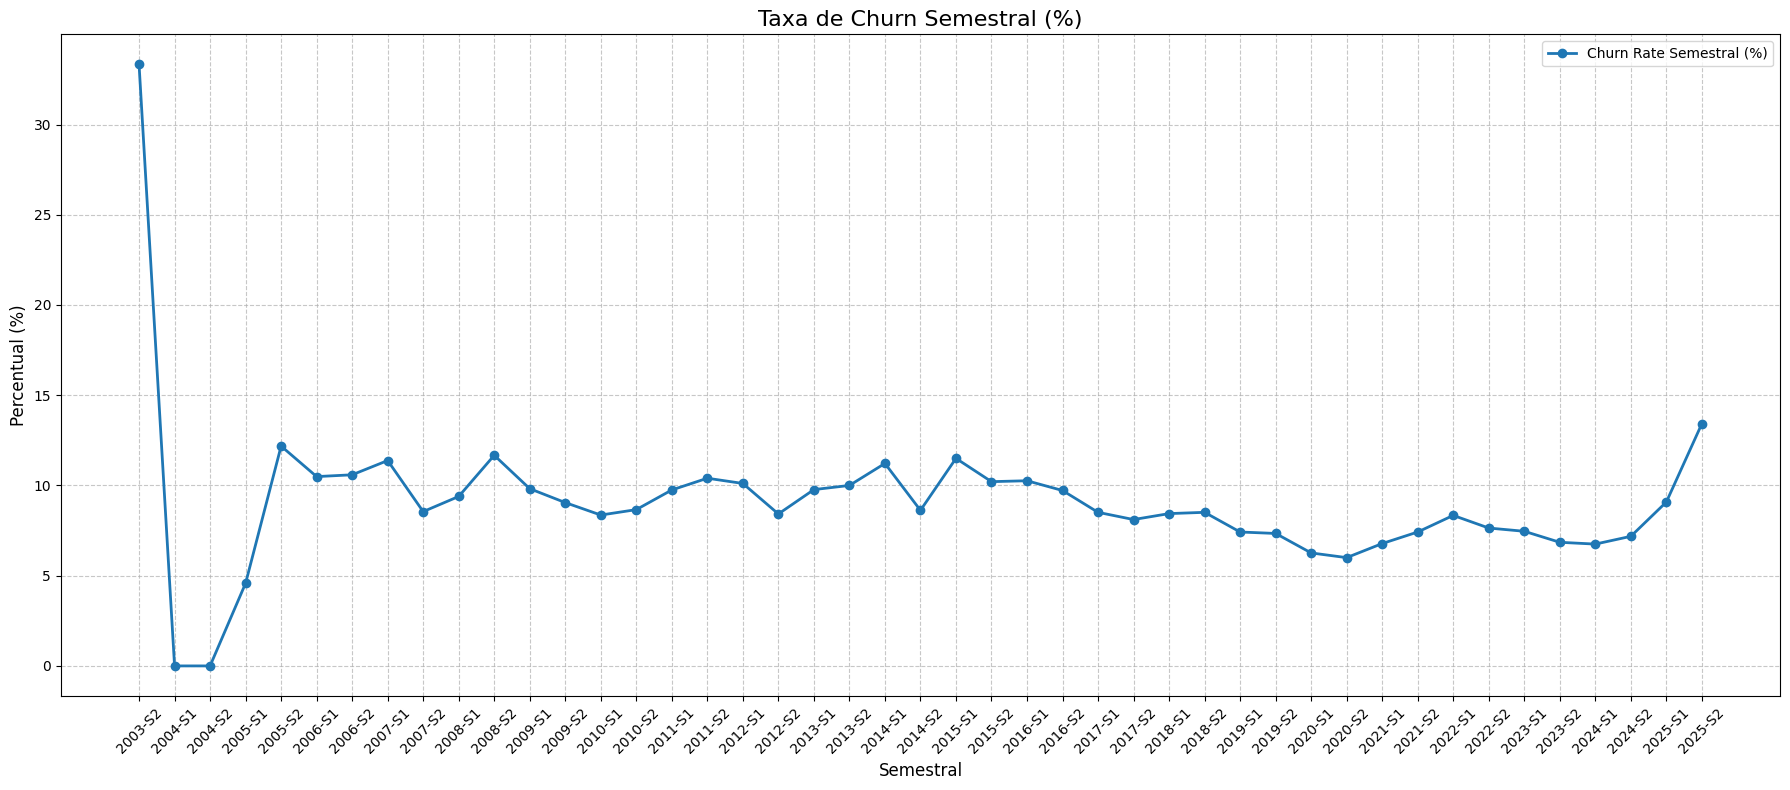

In [6]:
plt.figure(figsize=(18,8))

plt.plot(
    df_churn_semestral["periodo_semestral"],
    df_churn_semestral["churn_rate_semestral_percentual"],
    marker='o',
    linewidth=2,
    label='Churn Rate Semestral (%)'
)

plt.title("Taxa de Churn Semestral (%)", fontsize=16)
plt.xlabel("Semestral", fontsize=12)
plt.ylabel("Percentual (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()